In [1]:
"""
Oversampling 하여 1000 epochs 실험 후 minor2한 data만으로 1 epoch tuning
"""


'\nOversampling 하여 1000 epochs 실험 후 minor한 data만으로 1 epoch tuning\n'

In [1]:
import tensorflow as tf
from keras.datasets import mnist
(img_train, label_train), (img_test, label_test) = mnist.load_data()

import numpy as np
import matplotlib.pyplot as plt
import time

Using TensorFlow backend.


In [2]:
# split test data
test_img = {}
for idx in range(10):
    test_img[idx] = []

for idx in range(len(img_test)):
    test_img[label_test[idx]].append(img_test[idx])
for num in range(10):
    test_img[num] = np.array(test_img[num])

for num in range(10):
    print("shape of {} : {}".format(num, test_img[num].shape))

shape of 0 : (980, 28, 28)
shape of 1 : (1135, 28, 28)
shape of 2 : (1032, 28, 28)
shape of 3 : (1010, 28, 28)
shape of 4 : (982, 28, 28)
shape of 5 : (892, 28, 28)
shape of 6 : (958, 28, 28)
shape of 7 : (1028, 28, 28)
shape of 8 : (974, 28, 28)
shape of 9 : (1009, 28, 28)


In [3]:
# split training data
org_image = {}
for idx in range(10):
    org_image[idx] = []

for idx in range(len(img_train)):
    org_image[label_train[idx]].append(img_train[idx])
for num in range(10):
    org_image[num] = np.array(org_image[num])

for num in range(10):
    print("shape of {} : {}".format(num, org_image[num].shape))

shape of 0 : (5923, 28, 28)
shape of 1 : (6742, 28, 28)
shape of 2 : (5958, 28, 28)
shape of 3 : (6131, 28, 28)
shape of 4 : (5842, 28, 28)
shape of 5 : (5421, 28, 28)
shape of 6 : (5918, 28, 28)
shape of 7 : (6265, 28, 28)
shape of 8 : (5851, 28, 28)
shape of 9 : (5949, 28, 28)


In [4]:
image = {}
#helper = [10, 10, 100, 100, 100, 300, 300, 1000, 1000, 1000]
helper = [1000, 1000, 300, 100, 100, 10, 10, 10, 10, 300]

for num in range(10):
    idxs = np.random.permutation(range(len(org_image[num])))
    image[num] = org_image[num][idxs[0:helper[num]]]
    print("The number of {} : {}".format(num, image[num].shape))

The number of 0 : (1000, 28, 28)
The number of 1 : (1000, 28, 28)
The number of 2 : (300, 28, 28)
The number of 3 : (100, 28, 28)
The number of 4 : (100, 28, 28)
The number of 5 : (10, 28, 28)
The number of 6 : (10, 28, 28)
The number of 7 : (10, 28, 28)
The number of 8 : (10, 28, 28)
The number of 9 : (300, 28, 28)


In [5]:
from keras.utils import np_utils

img_row, img_col = img_train.shape[1], img_train.shape[2]
img_depth = 1

img_train = img_train.reshape(img_train.shape[0], img_row, img_col, img_depth)
img_test = img_test.reshape(img_test.shape[0], img_row, img_col, img_depth)
img_train = img_train.astype('float32')
img_test = img_test.astype('float32')
img_train /= 255
img_test /= 255

label_train = np_utils.to_categorical(label_train, 10)
label_test = np_utils.to_categorical(label_test, 10)

In [6]:
W = np.load('./Weights/weights_transfer_Conv1_Fc1_minor2_epcoh1.npy')

In [7]:
X = tf.placeholder(tf.float32, [None, img_row, img_col, img_depth])
Y = tf.placeholder(tf.float32, [None, 10])
training = tf.placeholder(tf.bool)

with tf.variable_scope('conv_layer'):
    conv1 = tf.layers.conv2d(inputs=X, filters=32, kernel_size=[3, 3], 
                             kernel_initializer=tf.constant_initializer(W[0]), bias_initializer=tf.constant_initializer(W[1]),
                            padding='SAME', activation=tf.nn.relu, name='conv1')
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], 
                                    padding='SAME', strides=2, name='pool1')
    conv2 = tf.layers.conv2d(inputs=pool1, filters=32, kernel_size=[3, 3], 
                             kernel_initializer=tf.constant_initializer(W[2]), bias_initializer=tf.constant_initializer(W[3]),
                            padding='SAME', activation=tf.nn.relu, name='conv2')
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], 
                                    padding='SAME', strides=2, name='pool2')
    conv3 = tf.layers.conv2d(inputs=pool2, filters=32, kernel_size=[3, 3],
                             kernel_initializer=tf.constant_initializer(W[4]), bias_initializer=tf.constant_initializer(W[5]),
                            padding='SAME', activation=tf.nn.relu, name='conv3')
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], 
                                padding='SAME', strides=2, name='pool3')
with tf.variable_scope('fc_layer'):
    flat = tf.reshape(pool3, [-1, 4*4*32], name='flat')
    dense1 = tf.layers.dense(inputs=flat, units=1024, activation=tf.nn.relu, 
                             kernel_initializer=tf.constant_initializer(W[6]), bias_initializer=tf.constant_initializer(W[7]),
                             name='dense1')
    drop1 = tf.layers.dropout(inputs=dense1, rate=0.5, training=training)
    dense2 = tf.layers.dense(inputs=drop1, units=512, activation=tf.nn.relu, 
                             kernel_initializer=tf.constant_initializer(W[8]), bias_initializer=tf.constant_initializer(W[9]),
                             name='dense2')
    drop2 = tf.layers.dropout(inputs=dense2, rate=0.5, training=training)
    logits = tf.layers.dense(inputs=drop2, units=10, 
                            kernel_initializer=tf.constant_initializer(W[10]), bias_initializer=tf.constant_initializer(W[11]),)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
def get_accuracy(sess, logits, img, label):
    if len(img) > 5000:
        num = int(len(img)/2)
        logit1 = sess.run(logits, feed_dict={X: img[0:num], Y: label[0:num], training: False})
        logit2 = sess.run(logits, feed_dict={X: img[num:num*2], Y: label[num:num*2], training: False})
        logit = np.concatenate((logit1, logit2), axis=0)
    else:
        num = len(img)
        logit = sess.run(logits, feed_dict={X: img, Y: label, training: False})
    
    equal = np.equal(np.argmax(logit, 1), np.argmax(label, 1))
    predict = equal.astype(np.float32)
    accuracy = np.mean(predict)
    
    return accuracy, predict, logit

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
test_accuracy, _, _ = get_accuracy(sess, logits, img_test, label_test)
print ('Test Accuracy : {:.5f}'.format(test_accuracy))

Test Accuracy : 0.95130


In [10]:
for num in range(10):
    specific_label = np_utils.to_categorical(np.full((len(test_img[num])), num), 10)
    specific_test_accuracy, test_predict, test_logit = get_accuracy(sess, logits, np.expand_dims(test_img[num], axis=-1), 
                                                                    specific_label)
    print("The specific accurcy of {} : {:.5f}".format(num, specific_test_accuracy))
acc, _, _ = get_accuracy(sess, logits, img_test, label_test)
print("Total accuracy : {:.5f}".format(acc))

The specific accurcy of 0 : 0.98061
The specific accurcy of 1 : 0.99207
The specific accurcy of 2 : 0.98450
The specific accurcy of 3 : 0.97327
The specific accurcy of 4 : 0.96334
The specific accurcy of 5 : 0.92713
The specific accurcy of 6 : 0.96451
The specific accurcy of 7 : 0.87646
The specific accurcy of 8 : 0.93532
The specific accurcy of 9 : 0.93162
Total accuracy : 0.95130


0.92713
65 / 892
The number of prediction as 0 : 2
The number of prediction as 2 : 1
The number of prediction as 3 : 20
The number of prediction as 4 : 3
The number of prediction as 6 : 7
The number of prediction as 7 : 2
The number of prediction as 8 : 23
The number of prediction as 9 : 7
wrong prediction
[3 8 3 4 3 7 9 3 3]
[3 6 4 8 8 8 3 8 8]
[8 4 8 9 3 8 3 3 9]
[8 6 8 0 8 3 8 8 6]
[3 3 7 9 9 6 8 8 9]
[8 8 8 8 6 9 8 3 2]
[8 3 3 8 3 3 3 3 6]
[0 6]
[]


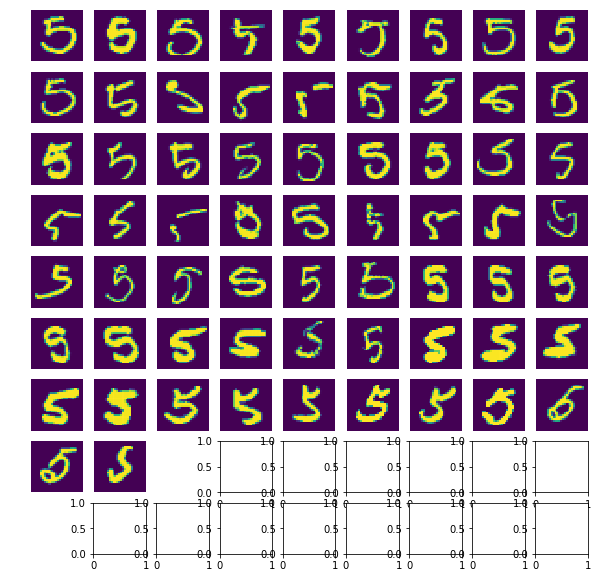

In [12]:
num = 5
specific_label = np_utils.to_categorical(np.full((len(test_img[num])), num), 10)
specific_test_accuracy, test_predict, test_logit = get_accuracy(sess, logits, np.expand_dims(test_img[num], axis=-1), specific_label)
print(specific_test_accuracy)

logit = np.argmax(test_logit, 1)
indx = np.where(test_predict[:] == 0.)[0]
print("{} / {}".format(len(indx), len(test_img[num])))
nrow = np.ceil(np.sqrt(len(indx))).astype(np.int)
fig, ax = plt.subplots(nrows=nrow, ncols=nrow, figsize = (10, 10))
img = test_img[num][indx]
for i in range(nrow):
    for j in range(nrow):
        if nrow*i+j >= len(indx):
            ax[i][j].axis('off')
            break
        else:
            ax[i][j].imshow(img[nrow*i+j])
            ax[i][j].axis('off')

logit = logit[indx]

logit_class = {}
for num in range(10):
    logit_class[num]= 0
    
for pred in logit:
    logit_class[pred] += 1
for num in range(10):
    if not logit_class[num] == 0:
        print('The number of prediction as {} : {}'.format(num, logit_class[num]))

print("wrong prediction")
for i in range(nrow):
    if nrow*(i+1) < len(indx):
        print(logit[nrow*i : nrow*(i+1)])
    else:
        print(logit[nrow*i : len(indx)])

plt.show()

0.964509
34 / 958
The number of prediction as 0 : 11
The number of prediction as 1 : 6
The number of prediction as 4 : 1
The number of prediction as 5 : 5
The number of prediction as 8 : 11
wrong prediction
[0 0 8 8 5 0]
[5 1 8 8 1 0]
[0 0 1 8 1 5]
[8 0 0 8 4 0]
[8 1 5 8 8 1]
[5 8 0 0]


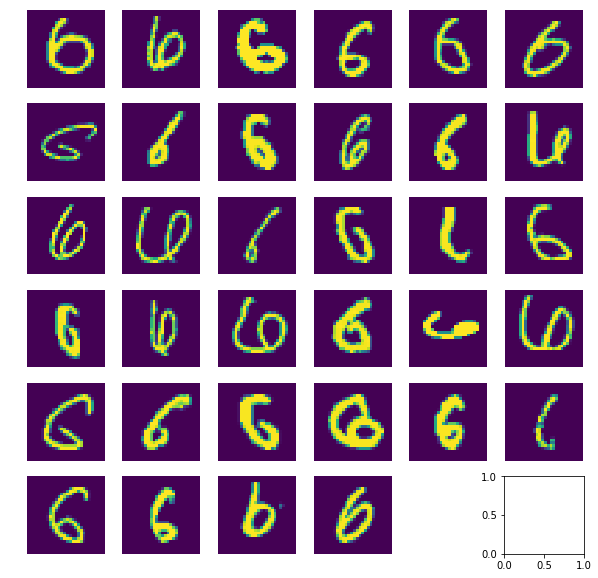

In [13]:
num = 6
specific_label = np_utils.to_categorical(np.full((len(test_img[num])), num), 10)
specific_test_accuracy, test_predict, test_logit = get_accuracy(sess, logits, np.expand_dims(test_img[num], axis=-1), specific_label)
print(specific_test_accuracy)

logit = np.argmax(test_logit, 1)
indx = np.where(test_predict[:] == 0.)[0]
print("{} / {}".format(len(indx), len(test_img[num])))
nrow = np.ceil(np.sqrt(len(indx))).astype(np.int)
fig, ax = plt.subplots(nrows=nrow, ncols=nrow, figsize = (10, 10))
img = test_img[num][indx]
for i in range(nrow):
    for j in range(nrow):
        if nrow*i+j >= len(indx):
            ax[i][j].axis('off')
            break
        else:
            ax[i][j].imshow(img[nrow*i+j])
            ax[i][j].axis('off')

logit = logit[indx]

logit_class = {}
for num in range(10):
    logit_class[num]= 0
    
for pred in logit:
    logit_class[pred] += 1
for num in range(10):
    if not logit_class[num] == 0:
        print('The number of prediction as {} : {}'.format(num, logit_class[num]))

print("wrong prediction")
for i in range(nrow):
    if nrow*(i+1) < len(indx):
        print(logit[nrow*i : nrow*(i+1)])
    else:
        print(logit[nrow*i : len(indx)])

plt.show()

0.876459
127 / 1028
The number of prediction as 1 : 4
The number of prediction as 2 : 45
The number of prediction as 3 : 26
The number of prediction as 4 : 16
The number of prediction as 5 : 4
The number of prediction as 6 : 1
The number of prediction as 8 : 5
The number of prediction as 9 : 26
wrong prediction
[3 9 3 2 4 3 3 3 3 3 4 2]
[3 3 2 2 2 5 9 3 3 2 4 2]
[2 3 8 8 2 2 1 2 2 9 4 9]
[2 9 3 2 9 2 4 3 6 3 5 2]
[9 9 2 3 2 4 2 2 3 2 2 2]
[4 2 4 5 3 8 2 1 4 2 9 3]
[9 2 2 2 9 2 2 1 4 8 2 9]
[4 9 9 3 2 2 3 9 4 3 2 3]
[4 9 2 9 9 2 4 2 1 3 2 9]
[9 9 9 8 9 9 4 9 5 2 2 2]
[2 3 2 2 3 4 9]
[]


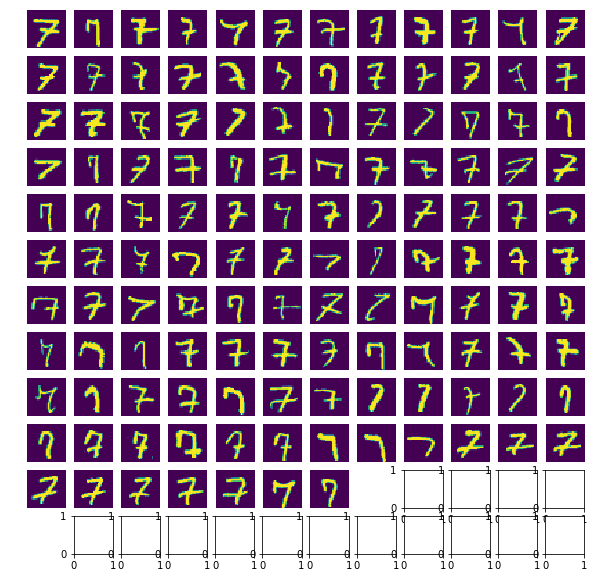

In [14]:
num = 7
specific_label = np_utils.to_categorical(np.full((len(test_img[num])), num), 10)
specific_test_accuracy, test_predict, test_logit = get_accuracy(sess, logits, np.expand_dims(test_img[num], axis=-1), specific_label)
print(specific_test_accuracy)

logit = np.argmax(test_logit, 1)
indx = np.where(test_predict[:] == 0.)[0]
print("{} / {}".format(len(indx), len(test_img[num])))
nrow = np.ceil(np.sqrt(len(indx))).astype(np.int)
fig, ax = plt.subplots(nrows=nrow, ncols=nrow, figsize = (10, 10))
img = test_img[num][indx]
for i in range(nrow):
    for j in range(nrow):
        if nrow*i+j >= len(indx):
            ax[i][j].axis('off')
            break
        else:
            ax[i][j].imshow(img[nrow*i+j])
            ax[i][j].axis('off')

logit = logit[indx]

logit_class = {}
for num in range(10):
    logit_class[num]= 0
    
for pred in logit:
    logit_class[pred] += 1
for num in range(10):
    if not logit_class[num] == 0:
        print('The number of prediction as {} : {}'.format(num, logit_class[num]))

print("wrong prediction")
for i in range(nrow):
    if nrow*(i+1) < len(indx):
        print(logit[nrow*i : nrow*(i+1)])
    else:
        print(logit[nrow*i : len(indx)])

plt.show()

0.935318
63 / 974
The number of prediction as 0 : 5
The number of prediction as 1 : 3
The number of prediction as 2 : 8
The number of prediction as 3 : 10
The number of prediction as 4 : 6
The number of prediction as 5 : 13
The number of prediction as 6 : 4
The number of prediction as 7 : 6
The number of prediction as 9 : 8
wrong prediction
[0 4 3 7 6 2 2 4]
[7 9 9 0 5 1 5 7]
[1 3 0 5 3 3 2 4]
[7 2 0 2 3 9 5 5]
[6 3 5 5 4 4 9 2]
[7 0 9 6 4 7 1 6]
[9 5 3 9 3 3 2 5]
[5 5 2 9 5 5 3]


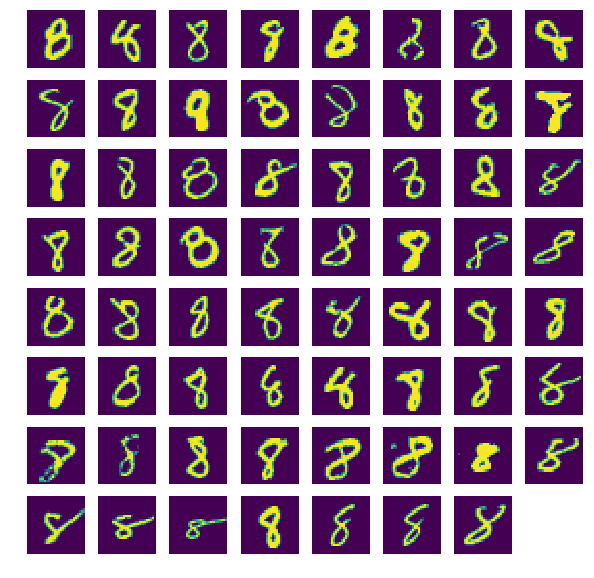

In [15]:
num = 8
specific_label = np_utils.to_categorical(np.full((len(test_img[num])), num), 10)
specific_test_accuracy, test_predict, test_logit = get_accuracy(sess, logits, np.expand_dims(test_img[num], axis=-1), specific_label)
print(specific_test_accuracy)

logit = np.argmax(test_logit, 1)
indx = np.where(test_predict[:] == 0.)[0]
print("{} / {}".format(len(indx), len(test_img[num])))
nrow = np.ceil(np.sqrt(len(indx))).astype(np.int)
fig, ax = plt.subplots(nrows=nrow, ncols=nrow, figsize = (10, 10))
img = test_img[num][indx]
for i in range(nrow):
    for j in range(nrow):
        if nrow*i+j >= len(indx):
            ax[i][j].axis('off')
            break
        else:
            ax[i][j].imshow(img[nrow*i+j])
            ax[i][j].axis('off')

logit = logit[indx]

logit_class = {}
for num in range(10):
    logit_class[num]= 0
    
for pred in logit:
    logit_class[pred] += 1
for num in range(10):
    if not logit_class[num] == 0:
        print('The number of prediction as {} : {}'.format(num, logit_class[num]))

print("wrong prediction")
for i in range(nrow):
    if nrow*(i+1) < len(indx):
        print(logit[nrow*i : nrow*(i+1)])
    else:
        print(logit[nrow*i : len(indx)])

plt.show()

0.931615
69 / 1009
The number of prediction as 0 : 3
The number of prediction as 1 : 9
The number of prediction as 3 : 4
The number of prediction as 4 : 16
The number of prediction as 5 : 19
The number of prediction as 7 : 12
The number of prediction as 8 : 6
wrong prediction
[7 1 5 8 1 8 5 8 1]
[4 5 4 3 5 4 5 1 5]
[8 1 4 7 7 7 5 4 1]
[3 7 1 5 7 5 5 4 5]
[5 3 4 3 4 1 4 1 4]
[0 5 5 0 5 7 5 5 0]
[7 4 4 7 4 8 7 4 7]
[7 8 4 5 5 4]
[]


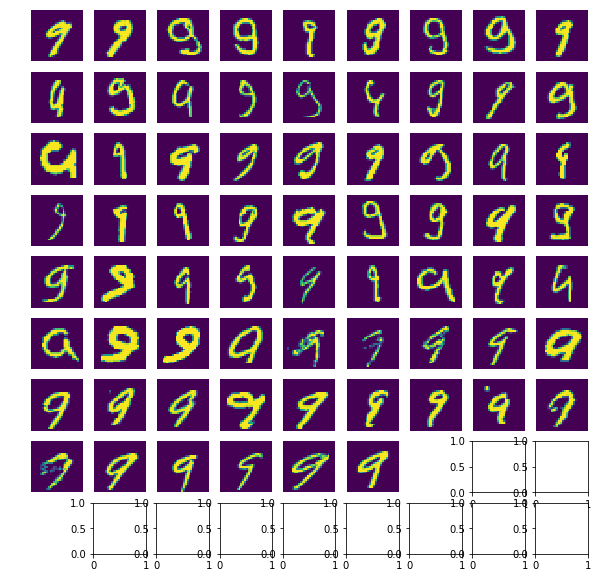

In [16]:
num = 9
specific_label = np_utils.to_categorical(np.full((len(test_img[num])), num), 10)
specific_test_accuracy, test_predict, test_logit = get_accuracy(sess, logits, np.expand_dims(test_img[num], axis=-1), specific_label)
print(specific_test_accuracy)

logit = np.argmax(test_logit, 1)
indx = np.where(test_predict[:] == 0.)[0]
print("{} / {}".format(len(indx), len(test_img[num])))
nrow = np.ceil(np.sqrt(len(indx))).astype(np.int)
fig, ax = plt.subplots(nrows=nrow, ncols=nrow, figsize = (10, 10))
img = test_img[num][indx]
for i in range(nrow):
    for j in range(nrow):
        if nrow*i+j >= len(indx):
            ax[i][j].axis('off')
            break
        else:
            ax[i][j].imshow(img[nrow*i+j])
            ax[i][j].axis('off')

logit = logit[indx]

logit_class = {}
for num in range(10):
    logit_class[num]= 0
    
for pred in logit:
    logit_class[pred] += 1
for num in range(10):
    if not logit_class[num] == 0:
        print('The number of prediction as {} : {}'.format(num, logit_class[num]))

print("wrong prediction")
for i in range(nrow):
    if nrow*(i+1) < len(indx):
        print(logit[nrow*i : nrow*(i+1)])
    else:
        print(logit[nrow*i : len(indx)])

plt.show()